# 03 Trade-off Analysis

We compare models across:
- WAPE and MAE (average accuracy)
- rolling error (stability)
- tail risk (p90/max error)
- shock-window performance

The main deliverable is a chart showing:
accuracy vs stability (rolling WAPE)


In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

DATA = Path("../data/processed/preds.parquet")

OUT_FIG = Path("../outputs/figures")
OUT_TAB = Path("../outputs/tables")
OUT_FIG.mkdir(parents=True, exist_ok=True)
OUT_TAB.mkdir(parents=True, exist_ok=True)

df = pd.read_parquet(DATA).sort_values("date").reset_index(drop=True)

def wape(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    return np.sum(np.abs(y-yhat)) / np.sum(np.abs(y))

def mae(y, yhat):
    return float(np.mean(np.abs(np.asarray(y)-np.asarray(yhat))))

def p90(y, yhat):
    return float(np.quantile(np.abs(np.asarray(y)-np.asarray(yhat)), 0.9))

def maxerr(y, yhat):
    return float(np.max(np.abs(np.asarray(y)-np.asarray(yhat))))

models = {
    "seasonal_7": "yhat_seasonal_7",
    "ridge": "yhat_ridge",
    "histgbm": "yhat_hgb",
    "random_forest": "yhat_rf"
}

rows = []
for name, col in models.items():
    rows.append({
        "model": name,
        "wape": wape(df["y"], df[col]),
        "mae": mae(df["y"], df[col]),
        "p90_abs_err": p90(df["y"], df[col]),
        "max_abs_err": maxerr(df["y"], df[col]),
        "wape_shock": wape(df.loc[df["is_shock_window"], "y"], df.loc[df["is_shock_window"], col])
    })

summary = pd.DataFrame(rows).sort_values("wape").reset_index(drop=True)
summary.to_csv(OUT_TAB / "benchmark_summary.csv", index=False)
summary


,model,wape,mae,p90_abs_err,max_abs_err,wape_shock
0,ridge,0.051242,6.331562,13.290530,31.299936,0.081558
1,seasonal_7,0.053472,6.607151,13.363428,41.709732,0.067529
2,random_forest,0.070592,8.722545,16.345008,30.909030,0.089954
3,histgbm,0.078700,9.724374,17.760315,25.718443,0.092769


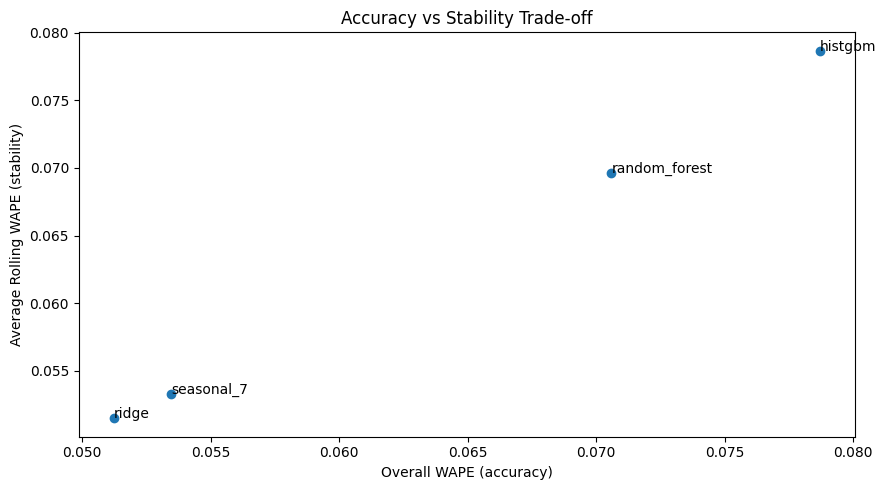

,model,wape,mae,p90_abs_err,max_abs_err,wape_shock,avg_rolling_wape,p90_rolling_wape
0,ridge,0.051242,6.331562,13.290530,31.299936,0.081558,0.051491,0.067033
1,seasonal_7,0.053472,6.607151,13.363428,41.709732,0.067529,0.053283,0.071180
2,random_forest,0.070592,8.722545,16.345008,30.909030,0.089954,0.069626,0.088295
3,histgbm,0.078700,9.724374,17.760315,25.718443,0.092769,0.078655,0.093109


In [2]:
WINDOW = 30

stability = []
for name, col in models.items():
    abs_err = (df["y"] - df[col]).abs()
    roll_wape = abs_err.rolling(WINDOW).sum() / df["y"].abs().rolling(WINDOW).sum()
    stability.append({
        "model": name,
        "avg_rolling_wape": float(roll_wape.mean()),
        "p90_rolling_wape": float(roll_wape.quantile(0.9))
    })

stab = pd.DataFrame(stability)

plot_df = summary.merge(stab, on="model", how="left")

plt.figure(figsize=(9,5))
plt.scatter(plot_df["wape"], plot_df["avg_rolling_wape"])

for _, r in plot_df.iterrows():
    plt.text(r["wape"], r["avg_rolling_wape"], r["model"])

plt.xlabel("Overall WAPE (accuracy)")
plt.ylabel("Average Rolling WAPE (stability)")
plt.title("Accuracy vs Stability Trade-off")
plt.tight_layout()
plt.savefig(OUT_FIG / "accuracy_vs_stability.png", dpi=200, bbox_inches="tight")
plt.show()

plot_df.sort_values("wape")
